In [10]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import models
from torchvision import transforms, utils
import skimage.io 

In [11]:
import numpy as np
import scipy.misc
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import json

In [12]:
def to_grayscale(image):
    """
    input is (d,w,h)
    converts 3D image tensor to grayscale images corresponding to each channel
    """
    image = torch.sum(image, dim=0)
    image = torch.div(image, image.shape[0])
    return image

In [13]:
def normalize(image):
    normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )
    preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
    ])
    image = Variable(preprocess(image).unsqueeze(0).cuda())
    return image


def predict(image):
    _, index = vgg(image).data[0].max(0)
    index = int(index)
    return str(index), labels[str(index)][1]
    
def deprocess(image):
    return image * torch.Tensor([0.229, 0.224, 0.225]).cuda()  + torch.Tensor([0.485, 0.456, 0.406]).cuda()

def load_image(path):
    image = skimage.io.imread(path)
    plt.imshow(image)
    plt.title("Image loaded successfully")
    return image

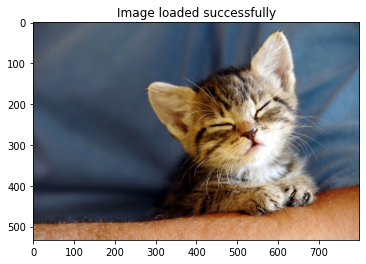

In [14]:
kitten_1 = load_image("https://i.imgur.com/jPShXp9.jpg")

In [15]:
vgg = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [16]:
vgg = vgg.cuda()

In [17]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
labels = json.load(open('labels/imagenet_class_index.json'))

In [ ]:
kitten_2 = normalize(kitten_1)
print(predict(kitten_2))

('281', 'tabby')


In [ ]:
modulelist = list(vgg.features.modules())

# Output of various layers

In [ ]:
def layer_outputs(image):
    outputs = []
    names = []
    for layer in modulelist[1:]:
        image = layer(image)
        outputs.append(image)
        names.append(str(layer))
        
    output_im = []
    for i in outputs:
        i = i.squeeze(0)
        temp = to_grayscale(i)
        output_im.append(temp.data.cpu().numpy())
        
    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (30, 50)


    for i in range(len(output_im)):
        a = fig.add_subplot(8,4,i+1)
        imgplot = plt.imshow(output_im[i])
        plt.axis('off')
        a.set_title(names[i].partition('(')[0], fontsize=15)

    plt.savefig('layer_outputs.jpg', bbox_inches='tight')

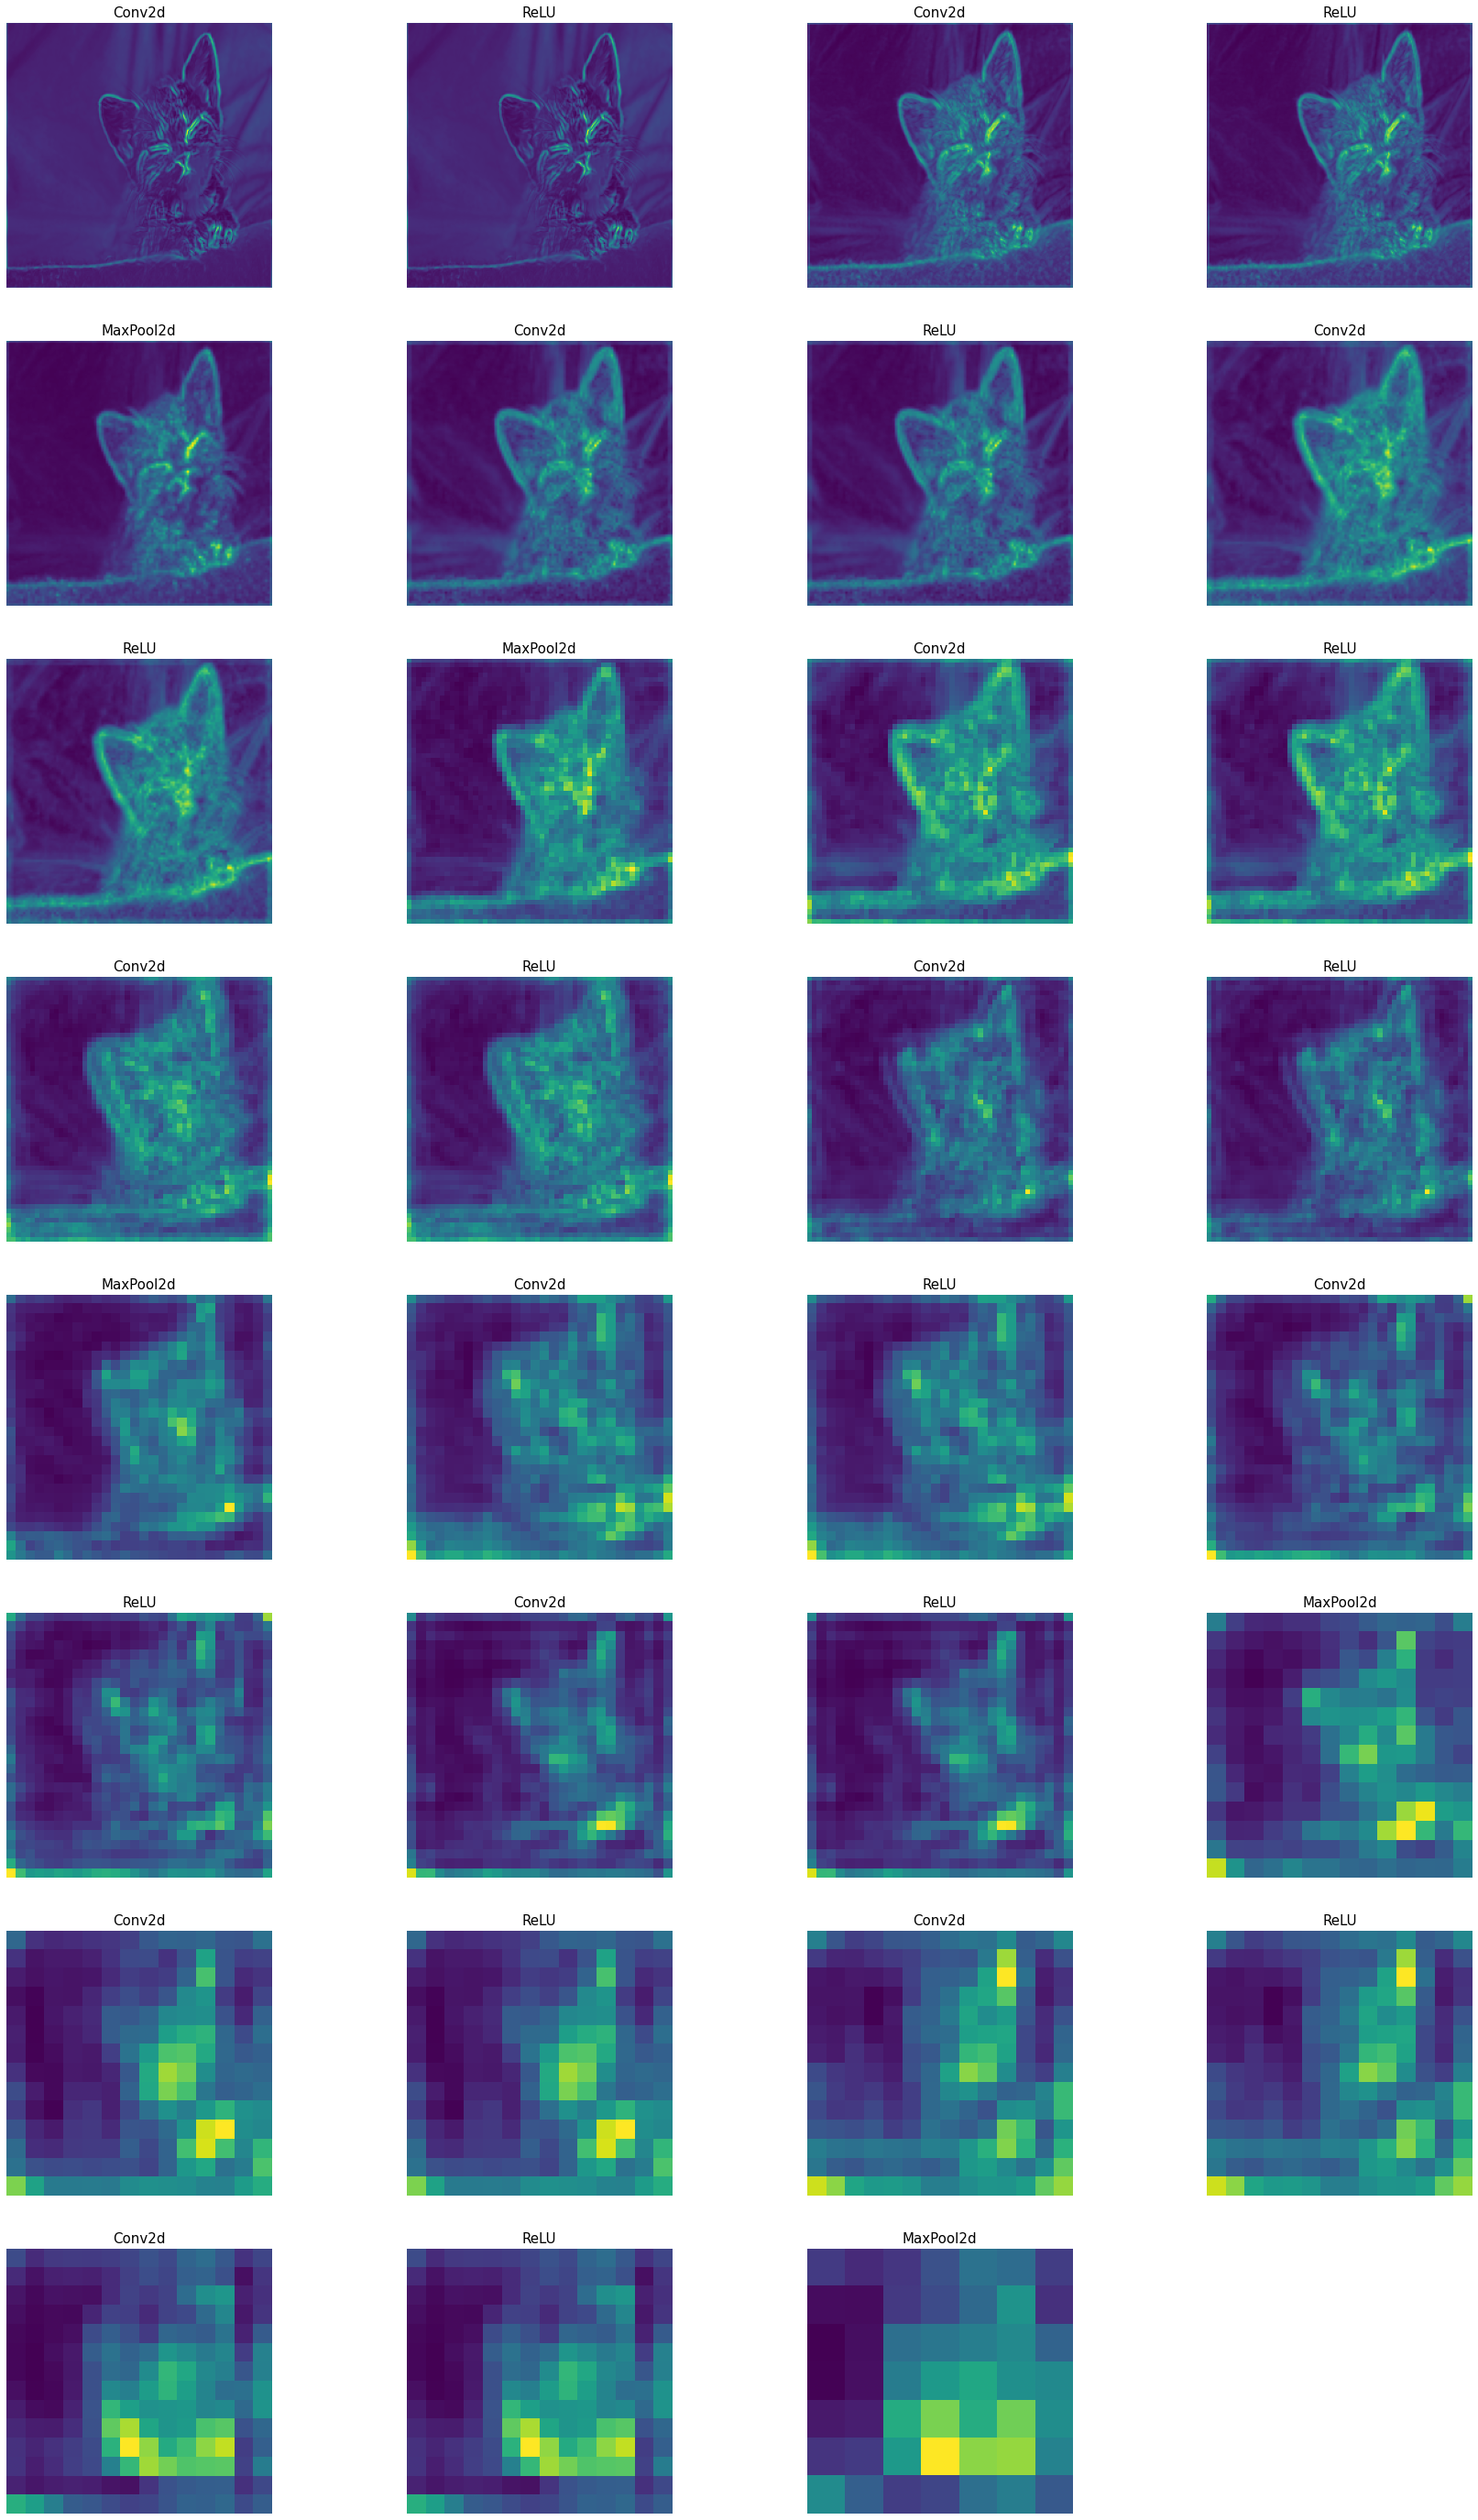

In [ ]:
layer_outputs(kitten_2)

# Output of each filter separately at given layer

In [ ]:
def filter_outputs(image, layer_to_visualize):
    if layer_to_visualize < 0:
        layer_to_visualize += 31
    output = None
    name = None
    for count, layer in enumerate(modulelist[1:]):
        image = layer(image)
        if count == layer_to_visualize: 
            output = image
            name = str(layer)
    
    filters = []
    output = output.data.squeeze()
    for i in range(output.shape[0]):
        filters.append(output[i,:,:])
        
    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (10, 10)

    for i in range(int(np.sqrt(len(filters))) * int(np.sqrt(len(filters)))):
        fig.add_subplot(np.sqrt(len(filters)), np.sqrt(len(filters)),i+1)
        
        imgplot = plt.imshow(filters[i].cpu().numpy())
        plt.axis('off')
    
#     print(len(filters))
#     print(filters[0].shape)
        
            
#     print(output.shape)

In [ ]:
filter_outputs(kitten_2, 0)

Output hidden; open in https://colab.research.google.com to view.

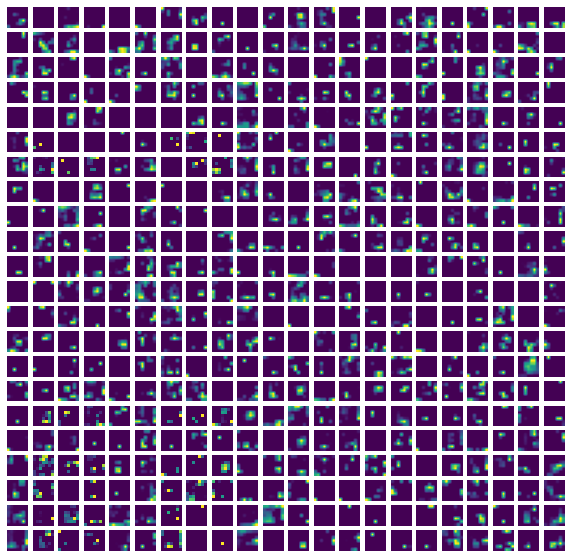

In [ ]:
filter_outputs(kitten_2, -1)

# Visualize weights

In [ ]:
def visualize_weights(image, layer):
    weight_used = []
    for w in vgg.features.children():
        if isinstance(w, torch.nn.modules.conv.Conv2d):
            weight_used.append(w.weight.data)

    filters = []
    for i in range(weight_used[layer].shape[0]):
        filters.append(weight_used[layer][i,:,:,:].sum(dim=0))
        filters[i].div(weight_used[layer].shape[1])
        
    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (10, 10)
    for i in range(int(np.sqrt(weight_used[layer].shape[0])) * int(np.sqrt(weight_used[layer].shape[0]))):
        a = fig.add_subplot(np.sqrt(weight_used[layer].shape[0]),np.sqrt(weight_used[layer].shape[0]),i+1)
        
        imgplot = plt.imshow(filters[i].cpu().numpy())
        plt.axis('off')

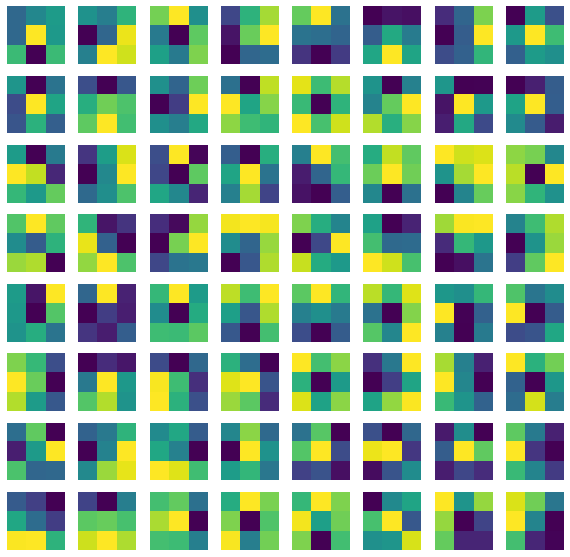

In [ ]:
# First conv layer filters
visualize_weights(kitten_2, 0)

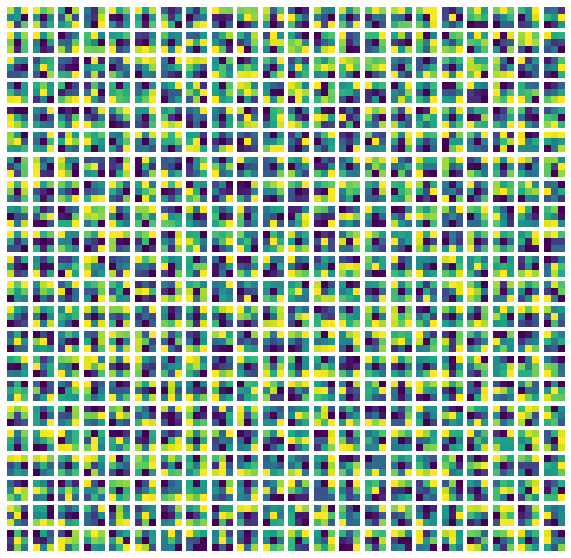

In [ ]:
# Last conv layer filters
visualize_weights(kitten_2, -1)

# CNN Heatmaps : Occlusion

In [ ]:
def make_heatmap(image, true_class, k=8, stride=8): 
    """
    Input image is of size (1, c, w, h) typically (1, 3, 224, 224) for vgg16
    true_class is a number corresponding to imagenet classes
    k in the filter size (c, k, k)
    """
    heatmap = torch.zeros(int(((image.shape[2]-k)/stride)+1), int(((image.shape[3]-k)/stride)+1))
    image = image.data

    i = 0
    a = 0
    while i<=image.shape[3]-k:
        j = 0 
        b = 0
        while j<=image.shape[2]-k:
            h_filter = torch.ones(image.shape)
            h_filter[:,:,j:j+k, i:i+k] = 0
            temp_image = Variable((image.cuda() * h_filter.cuda()).cuda())
            temp_softmax = vgg(temp_image)
            temp_softmax = torch.nn.functional.softmax(temp_softmax).data[0]
            heatmap[a][b] = temp_softmax[true_class]
            j += stride
            b += 1
        print(a)
        i += stride
        a += 1
    
    image = image.squeeze()
    
    true_image = image.transpose(0,1)
    true_image = true_image.transpose(1,2)
    # Un-Normalize image
    true_image = true_image * torch.Tensor([0.229, 0.224, 0.225]).cuda()  + torch.Tensor([0.485, 0.456, 0.406]).cuda()
    
    # Plot both images
    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (20, 20)
    
    a = fig.add_subplot(1,2,1)
    imgplot = plt.imshow(true_image.cpu().numpy())
    plt.title('Original Image')
    plt.axis('off') 
    
    # Normalize heatmap
    heatmap = heatmap - heatmap.min()
#     heatmap = heatmap/heatmap.max()
    heatmap = np.uint8(255 * heatmap)
    
    a = fig.add_subplot(1,2,2)
    imgplot = plt.imshow(heatmap)
    plt.title('Heatmap')
    plt.axis('off') 
    
    return heatmap
                    

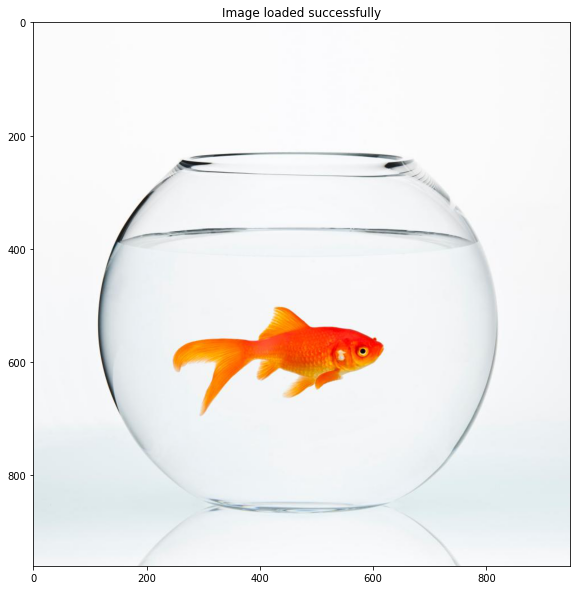

In [ ]:
my_img = load_image("images/goldfish.jpg")

In [ ]:
my_img = normalize(my_img)

In [ ]:
predict(my_img)

('1', 'goldfish')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26


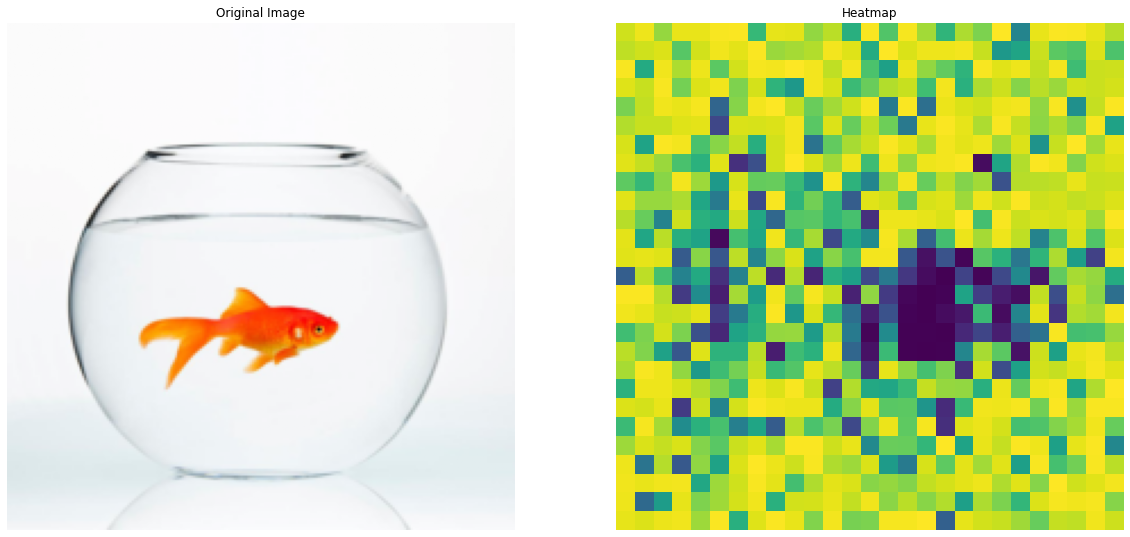

In [ ]:
goldfish_heatmap = make_heatmap(my_img, 1, 16, 8)  # Extremely slow

### TODO: Heatmap by CAM algorithm

# Class Specific Saliency Maps

In [ ]:
normalise = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )
preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalise
    ])

In [ ]:
def make_saliency_map(input, label):
    input = Variable(preprocess(input).unsqueeze(0).cuda(), requires_grad=True)
    output = vgg.forward(input)
    output[0][label].backward()
    grads = input.grad.data.clamp(min=0)
    grads.squeeze_()
    grads.transpose_(0,1)
    grads.transpose_(1,2)
    grads = np.amax(grads.cpu().numpy(), axis=2)
    
    true_image = input.data
    true_image = true_image.squeeze()
    true_image = true_image.transpose(0,1)
    true_image = true_image.transpose(1,2)
    true_image = deprocess(true_image)

    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (20, 20)


    a = fig.add_subplot(1,2,1)
    imgplot = plt.imshow(true_image.cpu().numpy())
    plt.title('Original Image')
    plt.axis('off') 

    a = fig.add_subplot(1,2,2)
    imgplot = plt.imshow(grads)
    plt.axis('off') 
    plt.title('Saliency Map')
    
    return grads

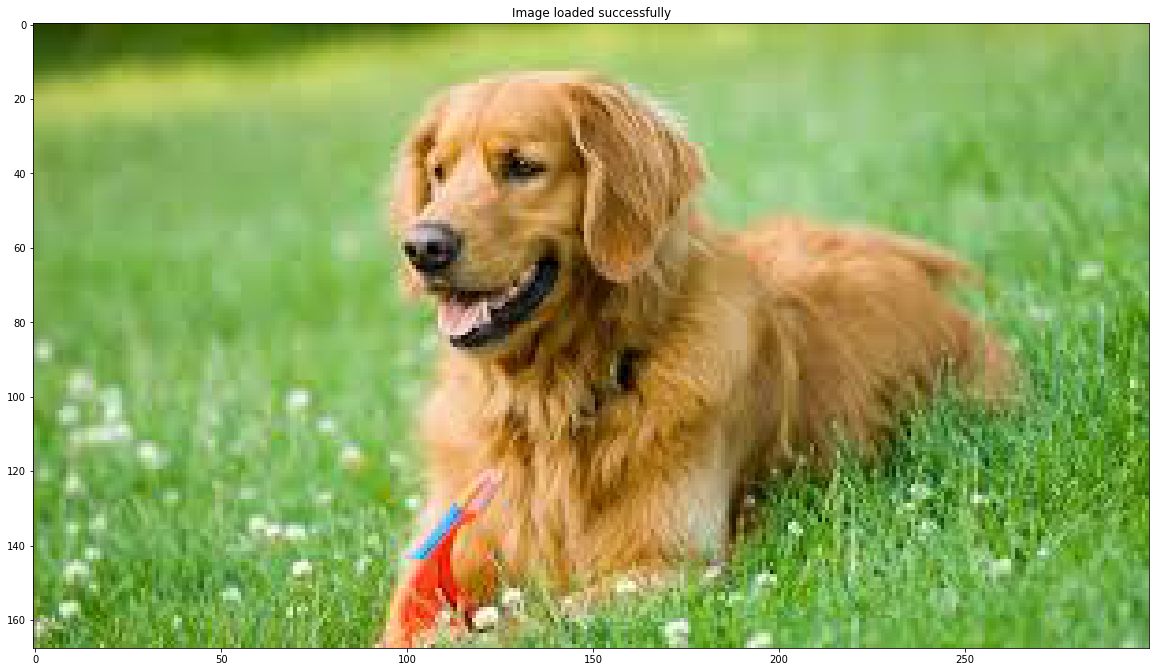

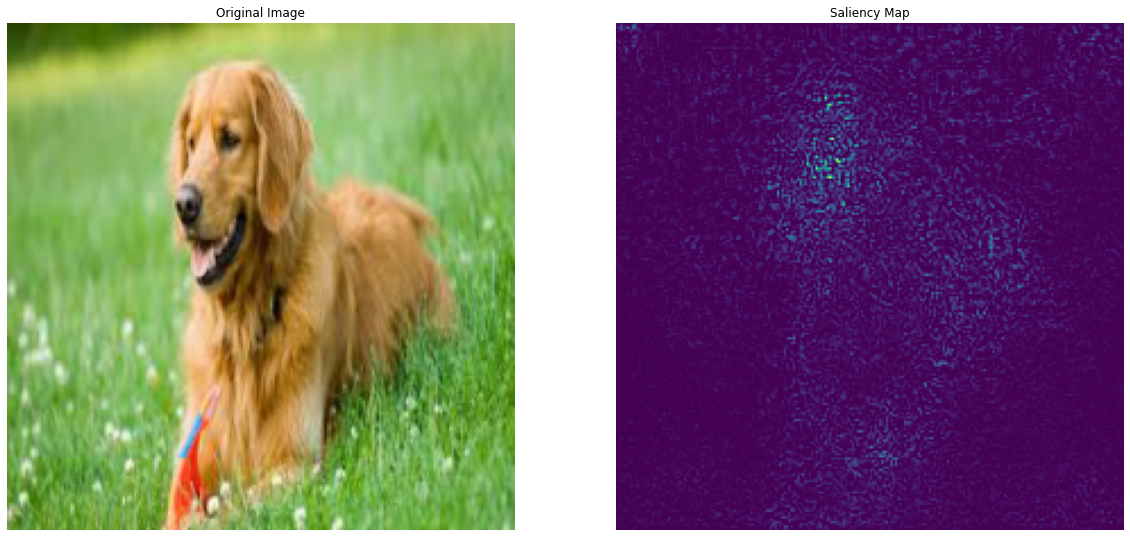

In [ ]:
dog = load_image('images/retr.jpeg')
dog_sal = make_saliency_map(dog, 207)

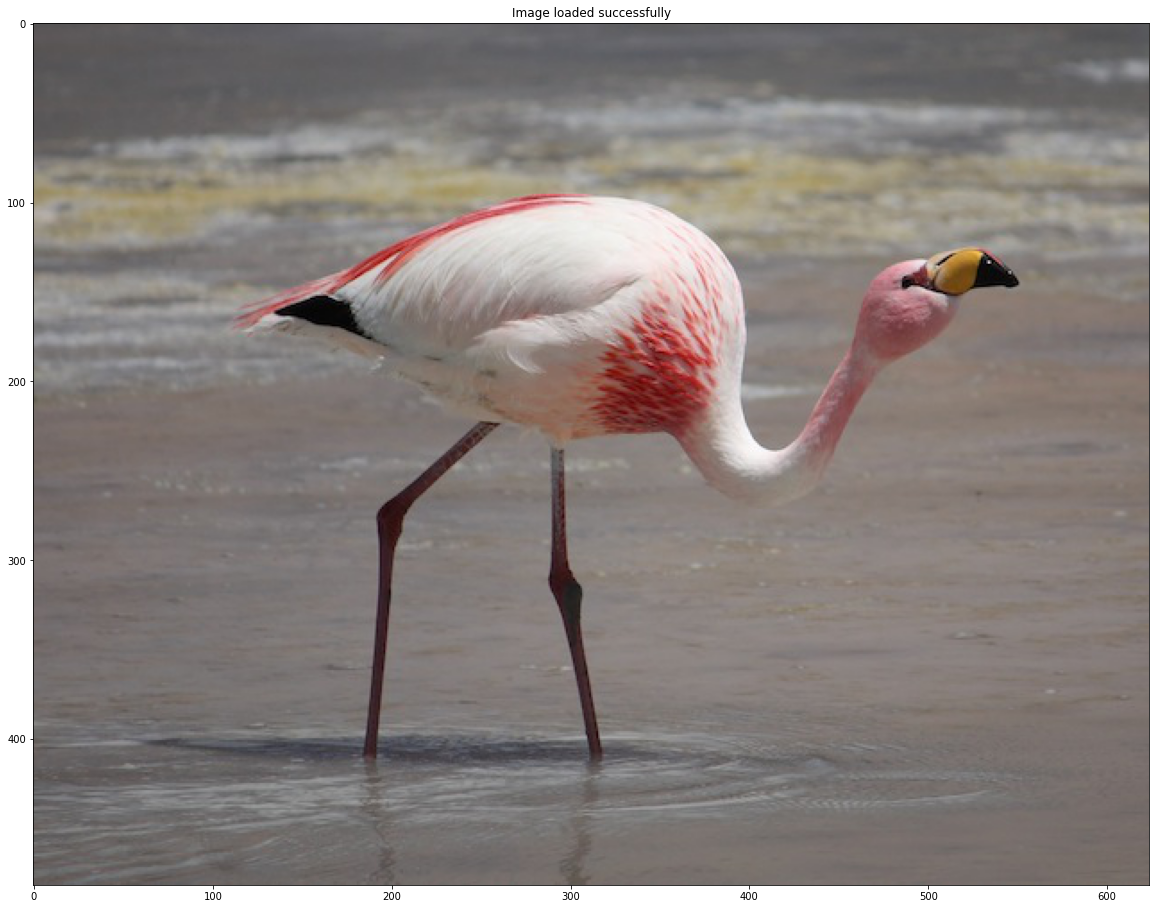

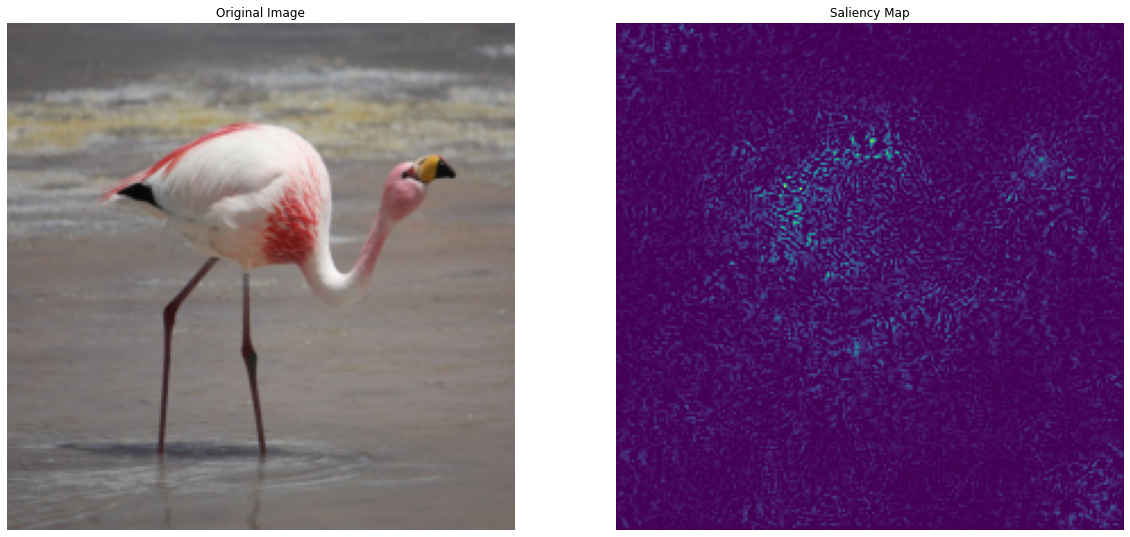

In [ ]:
flamingo = load_image('images/flamingo.jpg')
flamingo_sal = make_saliency_map(flamingo, 130)

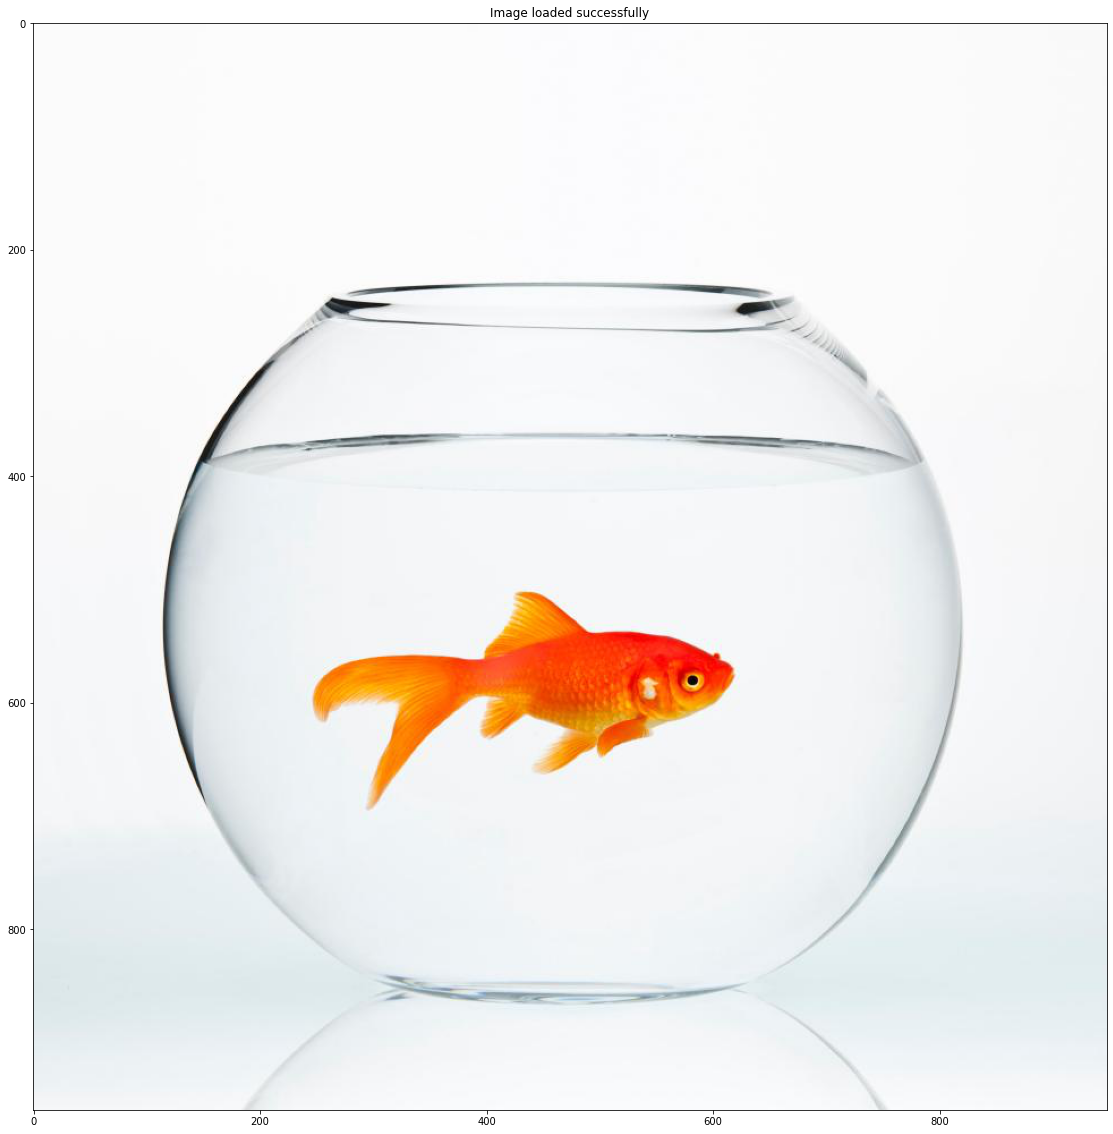

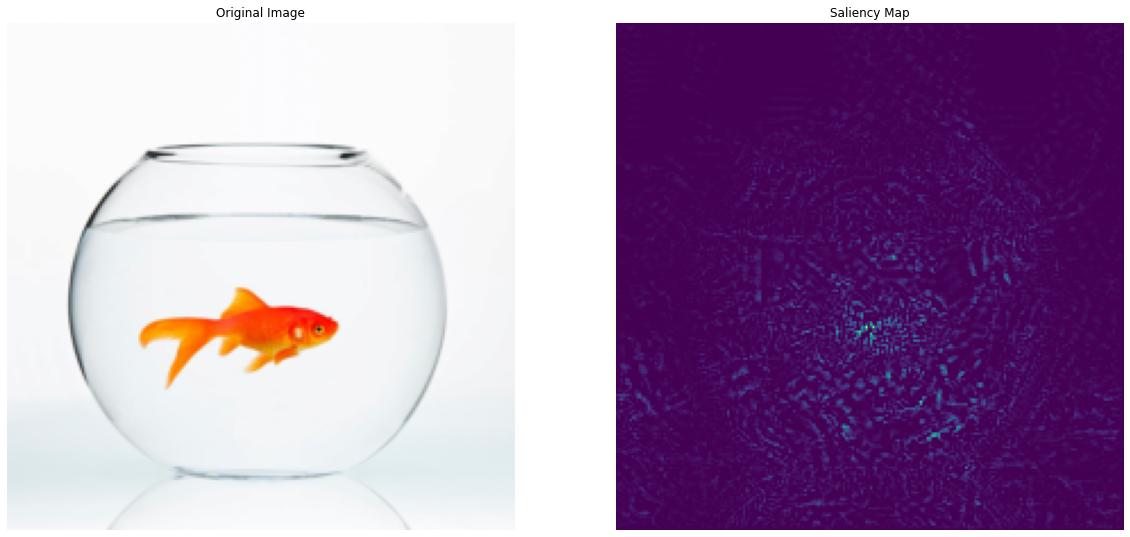

In [ ]:
goldfish = load_image('images/goldfish.jpg')
goldfish_sal = make_saliency_map(goldfish, 1)

# SmoothGrad

In [ ]:
def smooth_grad(input, label, x=10, percent_noise=10):
    """
    The apparent noise one sees in a sensitivity map may be due to 
    essentially meaningless local variations in partial derivatives.
    After all, given typical training techniques there is no reason to expect derivatives to vary smoothly.
    """
    tensor_input = torch.from_numpy(np.array(input)).type(torch.cuda.FloatTensor) # input is now of shape (w,h,c)
    # x is the sample size
    final_grad = torch.zeros((1,3,224,224)).cuda()
    for i in range(x):
        print('Sample:', i+1)
        temp_input = tensor_input
        # According to the paper, noise level corrresponds to stddev/(xmax-xmin). Hence stddev = noise_percentage * (max-min) /100
        noise = torch.from_numpy(np.random.normal(loc=0, scale=(percent_noise/100) * (tensor_input.max() - tensor_input.min()), size=temp_input.shape)).type(torch.cuda.FloatTensor)
        temp_input = (temp_input + noise).cpu().numpy()
        temp_input = Image.fromarray(temp_input.astype(np.uint8))
        temp_input = Variable(preprocess(temp_input).unsqueeze(0).cuda(), requires_grad=True)

        output = vgg.forward(temp_input)
        output[0][label].backward()
        final_grad += temp_input.grad.data
    
    grads = final_grad/x
    grads = grads.clamp(min=0)
    grads.squeeze_()
    grads.transpose_(0,1)
    grads.transpose_(1,2)
    grads = np.amax(grads.cpu().numpy(), axis=2)
    
    true_image = normalize(input)
    true_image = true_image.squeeze()
    true_image = true_image.transpose(0,1)
    true_image = true_image.transpose(1,2)
    true_image = deprocess(true_image.data)

    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (20, 20)


    a = fig.add_subplot(1,2,1)
    imgplot = plt.imshow(true_image)
    plt.title('Original Image')
    plt.axis('off') 

    a = fig.add_subplot(1,2,2)
    imgplot = plt.imshow(grads)
    plt.axis('off')  
    plt.title('SmoothGrad, Noise: ' + str(percent_noise) + '%, ' + 'Samples: ' + str(x))
    
    return grads

Sample: 1


TypeError: ignored

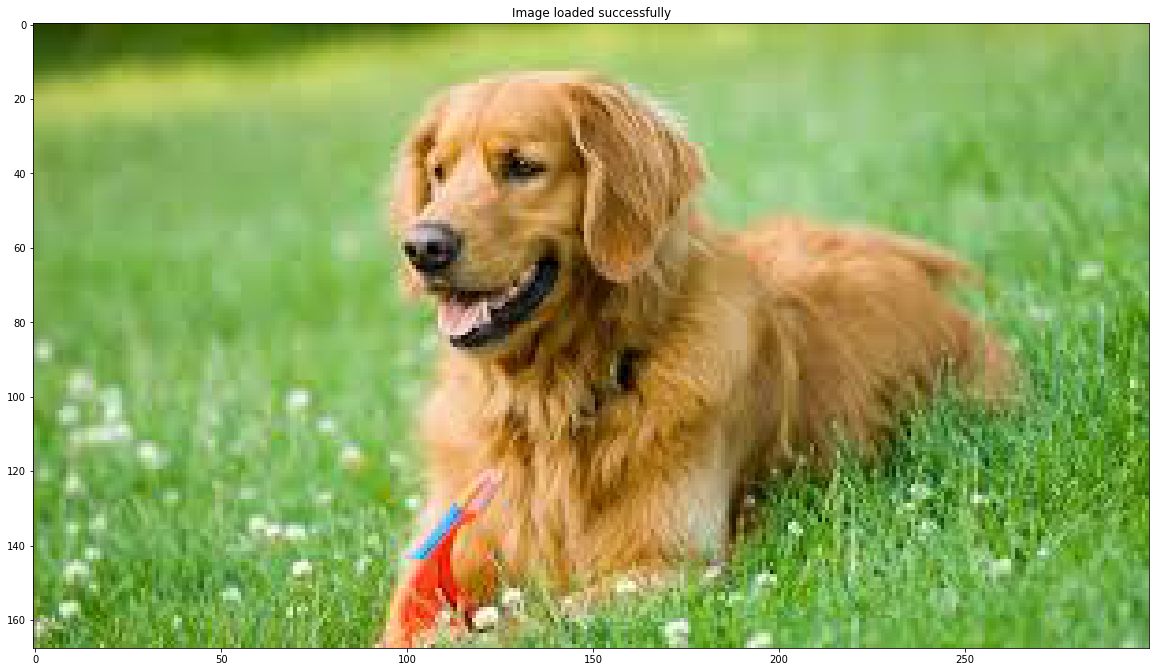

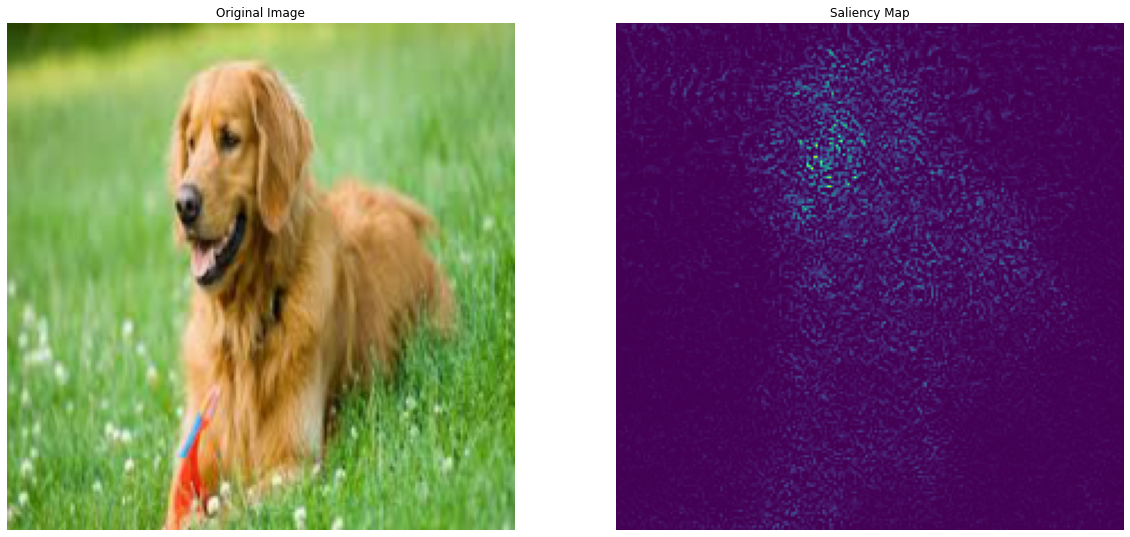

In [ ]:
dog_sg = load_image('images/retr.jpeg')
dog_sal = make_saliency_map(dog_sg, 1)
dog_sg_sal = smooth_grad(dog, 207, 30, 10)

Sample: 1


TypeError: ignored

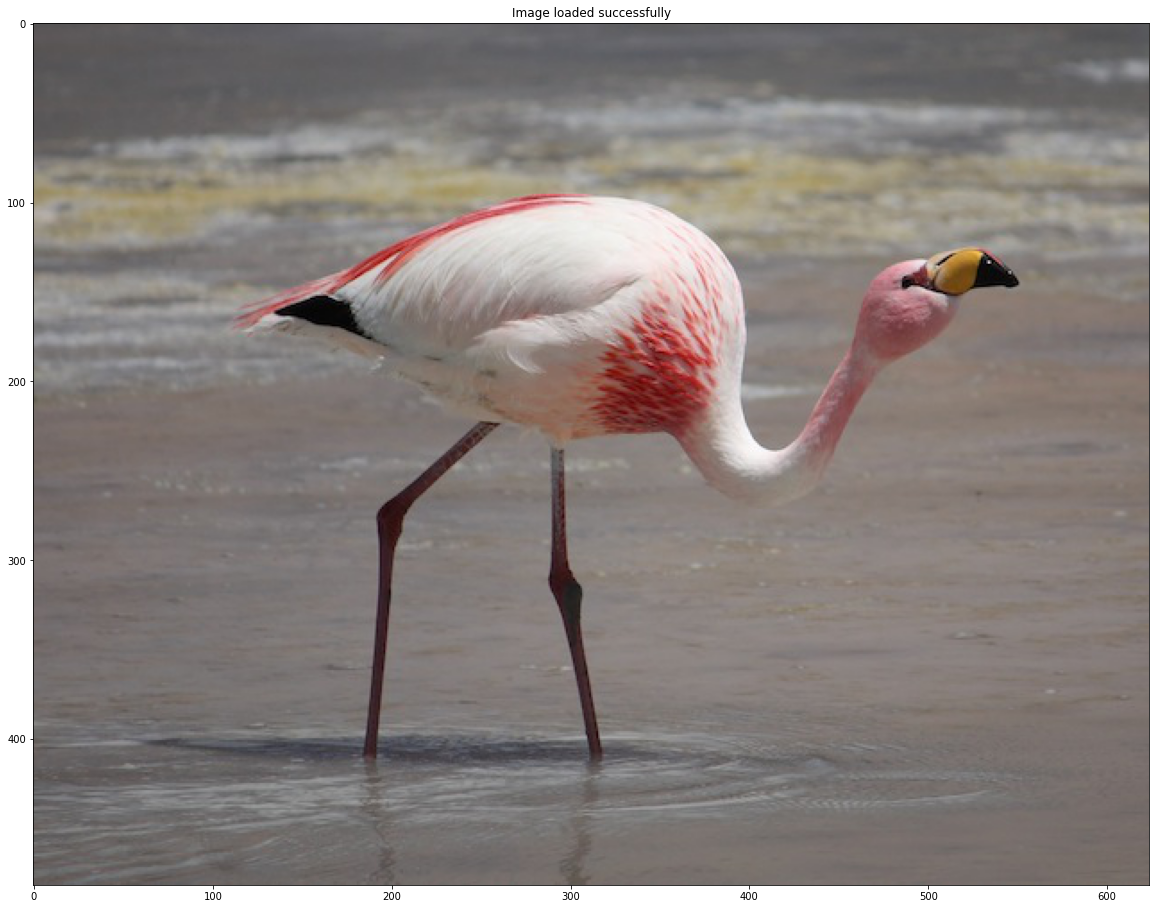

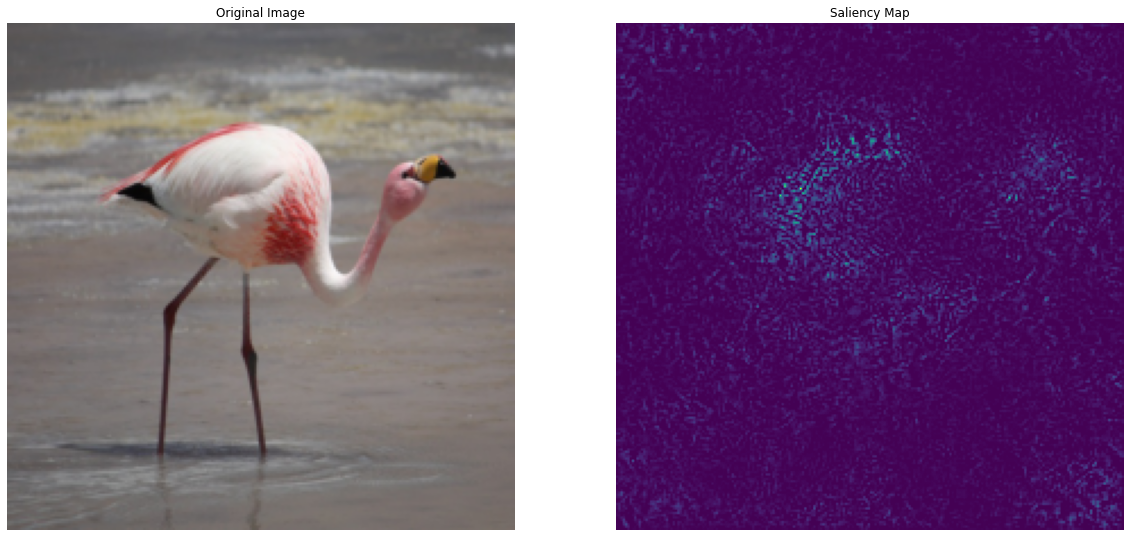

In [ ]:
flamingo_sg = load_image('images/flamingo.jpg')
flamingo_sal = make_saliency_map(flamingo_sg, 130)
flamingo_sg_sal = smooth_grad(flamingo_sg, 130, 20, 20)

Sample: 1


TypeError: ignored

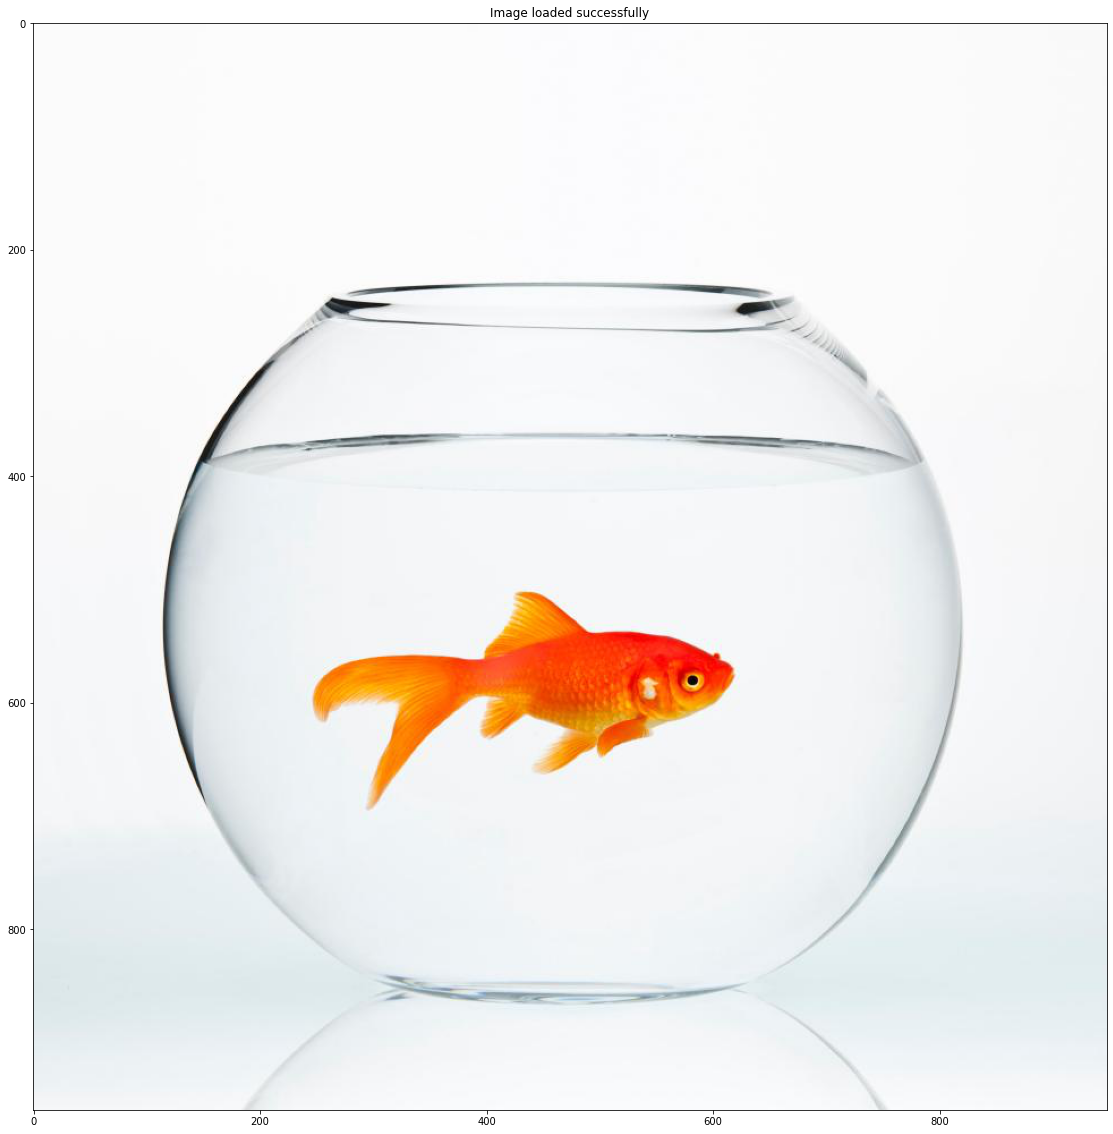

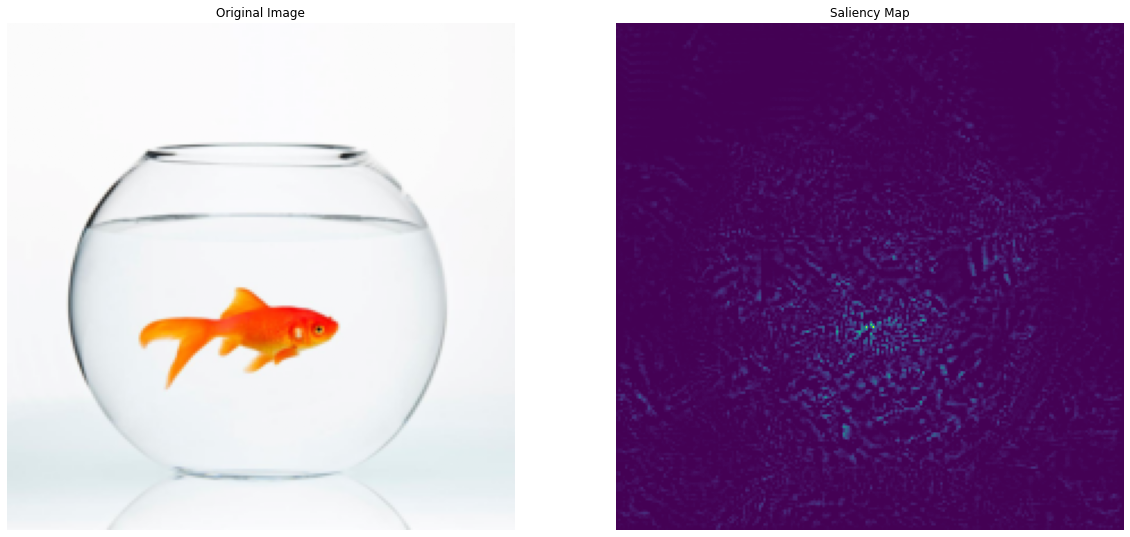

In [ ]:
goldfish_sg = load_image('images/goldfish.jpg')
godlfish_sal = make_saliency_map(goldfish_sg, 1)
goldfish_sg_sal = smooth_grad(goldfish, 1, 30, 10)

### TODO: SEMANTIC SEGMENTATION USING SMOOTHGRAD SALIENCY MAPS

# Class Models

In [ ]:
def make_class_map(label, iterations=100, lr=250, reg=1):
    cmap = np.zeros((224,224,3))
    mean = np.array([0.485, 0.456, 0.406])
    cmap += mean
#     plt.imshow(map)
    cmap = cmap.transpose(2,1,0)
    cmap = Variable(torch.Tensor(cmap).unsqueeze(0).cuda(), requires_grad=True)
#     cmap.data.shape
    for i in range(iterations):
    
        vgg.zero_grad()
        output = vgg(cmap)
#         print(i+1)
        class_score = output[0][label]
        reg_out = class_score + reg * cmap.norm()
        reg_out.backward()

        cmap.data = cmap.data + lr * cmap.grad.data
        
        
    cmap = cmap.data.squeeze()
    cmap.transpose_(0,1)
    cmap.transpose_(1,2)
    cmap = np.clip(np.array(deprocess(cmap).cpu()),0,255).astype('uint8')
    plt.figure(figsize=(5,5))
    plt.imshow(cmap)
    plt.axis('off')

    plt.title(labels[str(label)][1])
    
    return cmap


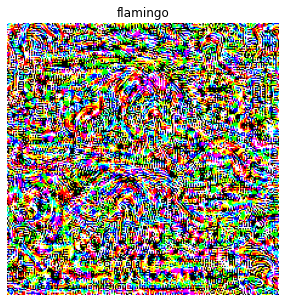

In [ ]:
flamingo_cmap = make_class_map(130, 1000, 300, 0.5)

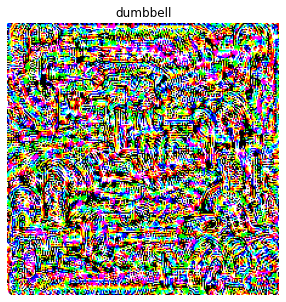

In [ ]:
dumbbell_cmap = make_class_map(543, 1000, 300, 0.5)